# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2023-spring@googlegroups.com

Slide:    [Link](https://docs.google.com/presentation/d/18LkR8qulwSbi3SVoLl1XNNGjQQ_qczs_35lrJWOmHCk/edit?usp=sharing)　Kaggle: [Link](https://www.kaggle.com/t/c76950cc460140eba30a576ca7668d28)

# Set up the environment


## Package installation

In [1]:
# Training progress bar
!pip install -q qqdm

## Downloading data

In [2]:
!git clone https://github.com/chiyuanhsiao/ml2023spring-hw8

Cloning into 'ml2023spring-hw8'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 2), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), 1.69 KiB | 864.00 KiB/s, done.
Filtering content: 100% (2/2), 1.36 GiB | 80.20 MiB/s, done.


# Import packages

In [3]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd

# Loading data

In [4]:

train = np.load('ml2023spring-hw8/trainingset.npy', allow_pickle=True)
test = np.load('ml2023spring-hw8/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [5]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(48763)

# Autoencoder

# Models & loss

In [6]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(), 
            nn.Linear(512, 256), 
            nn.ReLU(), 
            nn.Linear(256, 128)
        )    # Hint: dimension of latent space can be adjusted
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(), 
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(), 
            nn.Linear(1024, 2048), 
            nn.ReLU(), 
            nn.Linear(2048, 64 * 64 * 3), 
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Reference: https://blog.csdn.net/iwill323/article/details/127919157?spm=1001.2101.3001.6650.2&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-127919157-blog-125292835.235%5Ev33%5Epc_relevant_default_base3&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-127919157-blog-125292835.235%5Ev33%5Epc_relevant_default_base3&utm_relevant_index=5
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        # (64, 64, 3)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 24, 4, stride=2, padding=1),  
            nn.BatchNorm2d(24),
            nn.ReLU(),

            nn.Conv2d(24, 24, 4, stride=2, padding=1), 
            nn.BatchNorm2d(24),
            nn.ReLU(),

            nn.Conv2d(24, 48, 4, stride=2, padding=1), 
            nn.BatchNorm2d(48),
            nn.ReLU(),

            nn.Conv2d(48, 96, 4, stride=2, padding=1), 
            nn.BatchNorm2d(96),
            nn.ReLU(),

            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(96*4*4, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 10),
            nn.BatchNorm1d(10),
            nn.ReLU()
        )   # Hint:  dimension of latent space can be adjusted
        self.decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 96*4*4),
            nn.BatchNorm1d(96*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (96, 4, 4)),
            
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        # Hint: can add more layers to encoder and decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
       
def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

## ResNet
### Reference: https://blog.csdn.net/iwill323/article/details/127919157?spm=1001.2101.3001.6650.2&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-127919157-blog-125292835.235%5Ev33%5Epc_relevant_default_base3&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-127919157-blog-125292835.235%5Ev33%5Epc_relevant_default_base3&utm_relevant_index=5


In [7]:
class Residual_Block(nn.Module):
  def __init__(self, ic, oc, stride = 1):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(ic, oc, kernel_size=3, padding=1, stride = stride),
        nn.BatchNorm2d(oc),
        nn.ReLU(inplace = True)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(oc, oc, kernel_size=3, padding=1),
        nn.BatchNorm2d(oc)
    )

    self.relu = nn.ReLU(inplace = True)

    self.downsample = None

    if stride != 1 or (ic != oc):
      self.downsample = nn.Sequential(
          nn.Conv2d(ic, oc, kernel_size = 1, stride = stride),
          nn.BatchNorm2d(oc),
      )
  
  def forward(self,x):
    residual = x
    out = self.conv1(x)
    out = self.conv2(out)
    if self.downsample:
      residual = self.downsample(x)

    out += residual
    return self.relu(out)


class ResNet(nn.Module):
  def __init__(self, block = Residual_Block, num_layers=[2,1,1,1]):
    super().__init__()
    self.preconv = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1, bias = False),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace = True),
    )

    self.layer0 = self.make_residual(block, 32,   64, num_layers[0], stride = 2)
    self.layer1 = self.make_residual(block, 64,  128, num_layers[1], stride = 2)
    self.layer2 = self.make_residual(block, 128, 128, num_layers[2], stride = 2)
    self.layer3 = self.make_residual(block, 128,  64, num_layers[3], stride = 2)

    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(64*4*4, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(inplace = True),
    )

    self.decoder = nn.Sequential(
        nn.Linear(64, 64*4*4),
        nn.BatchNorm1d(64*4*4),
        nn.ReLU(),
        nn.Unflatten(1, (64,4,4)),
        nn.ConvTranspose2d(64, 128, 4, stride = 2, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 3, 4, stride = 2, padding = 1),
        nn.Tanh(),
    )

  def make_residual(self, block, ic, oc, num_layer, stride = 1):
    layers = []
    layers.append(block(ic, oc, stride ))
    for i in range(1, num_layer):
      layers.append(block(oc,oc))
    return nn.Sequential(*layers)

  def encoder(self, x):
    x = self.preconv(x)
    x = self.layer0(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.fc(x)
    return x

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


class Auxiliary(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(64, 64*4*4),
        nn.BatchNorm1d(64*4*4),
        nn.ReLU(),
        nn.Unflatten(1, (64,4,4)),
        nn.ConvTranspose2d(64, 128, 4, stride = 2, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 3, 4, stride = 2, padding = 1),
        nn.Tanh(),
    )

  def forward(self, x): 
    return self.decoder(x)


# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [8]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [9]:
# Training hyperparameters
batch_size = 256 # Hint: batch size may be lower
learning_rate = 8e-4

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'resnet'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE(), 'resnet':ResNet()}
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.8)

## Training loop

In [10]:
import os

In [11]:
config = {
    "num_epochs": 300,
    "lr" : 8e-4,
    "model_type":'resnet',
    "T_0": 2,
    "T_2": 2,
    'ratio_min':20
}

# config['model_path'] = "./models" + config['model_type']

model_clases = {'fcn':fcn_autoencoder(), ' cnn': conv_autoencoder(), 'vae':VAE(), 'resnet':ResNet()}
model = model_classes[config['model_type']].cuda()
# model.load_state_dict(torch.load('./best_model_fcn.pt))

aux = Auxiliary().cuda()


In [12]:
best_loss = np.inf
def trainer(model, config, train_dataloader, devices):
  best_loss = np.inf
  num_epochs = config['num_epochs']
  model_type = config["model_type"]

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = config["lr"])
  optimizer_a = torch.optim.AdamW(aux.parameters(), lr = config["lr"])
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = config['T_0'], T_mult = config['T_2'], eta_min = config['lr']/config['ratio_min'])

  if not os.path.isdir("./Checkpoint"):
    os.mkdir("./Checkpoint")
  
  aux.train()
  legend = ['train loss']
  # animator = d2l.Animator(xlabel = 'epoch', xlim = [1, num_epochs], legend = legend)
  
  for epoch in range(num_epochs):
    tot_loss, tot_loss_a = 0.0, 0.0
    temperature = epoch//2+1
    for data in train_dataloader:
      img = data.float().to("cuda")
      if model_type in ['fcn']:
          img = img.view(img.shape[0], -1)

      # ===================forward=====================
      model.train()
      output = model(img)
      if model_type in ['vae']:
          loss = loss_vae(output[0], img, output[1], output[2], criterion)
      else:
          loss = criterion(output, img)

      tot_loss += loss.item()
      # ===================backward====================
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # ===================train aux====================
      model.eval()
      z = model.encoder(img).detach_()
      output = output.detach_()
      output_a = aux(z)
      loss_a = (criterion(output_a, output).mul(temperature).exp())*criterion(output_a, img)
      tot_loss_a += loss_a.item()
      optimizer_a.zero_grad()
      loss_a.backward()
      optimizer_a.step()

    scheduler.step()

    # ===================save_best====================
    mean_loss = tot_loss / len(train_dataloader)
    print(epoch, mean_loss)
    # animator.add(epoch, (mean_loss))
    if mean_loss < best_loss:
      best_loss = mean_loss
      torch.save(model.state_dict(),"./Checkpoint/" + 'res')
      torch.save(aux.state_dict(), "./Checkpoint/" + 'aux')


trainer(model, config, train_dataloader, "cuda")


0 0.13798333456754075
1 0.07430690281150286
2 0.0644099744384551
3 0.05680477332390483
4 0.05263542196215571
5 0.05047848231880866
6 0.05246927486280041
7 0.049853461449179806
8 0.04803332818857849
9 0.04780393445392704
10 0.04625213075705501
11 0.04519955680498382
12 0.04437344556536211
13 0.04384360067984637
14 0.04728308371494493
15 0.045435512681370194
16 0.04445090222046198
17 0.04349194590926475
18 0.043658935600686864
19 0.04273841596777787
20 0.04267465040240141
21 0.04165502120276241
22 0.04100914995955384
23 0.04072215638654616
24 0.04030934581175789
25 0.0400009437385575
26 0.03971207565854273
27 0.03947722183926331
28 0.039343900845178865
29 0.039251563141641715
30 0.04131057908963364
31 0.04175669811380184
32 0.04110848500638667
33 0.040305712205522204
34 0.04011050996649296
35 0.04007765435425522
36 0.03993452291773713
37 0.03935955997432589
38 0.039011054331689235
39 0.03898511875582778
40 0.03886309011703562
41 0.03869700443256847
42 0.038523494768554295
43 0.0381740571

# Inference
Model is loaded and generates its anomaly score predictions.

總長度是19636, batch數量是 19.18


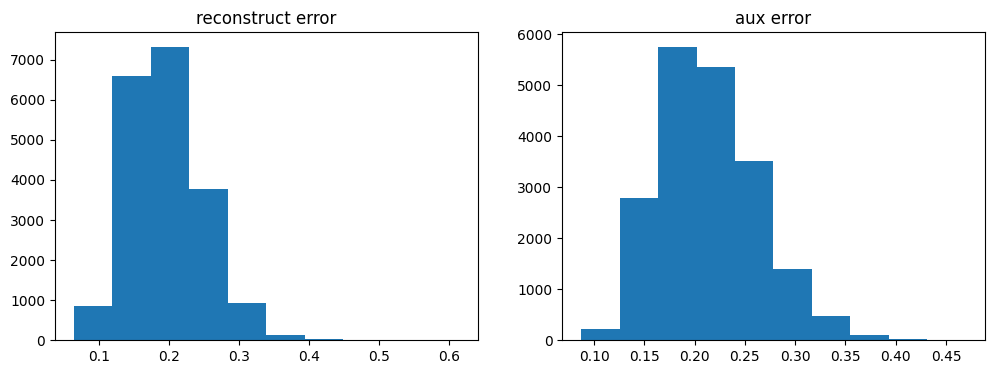

In [13]:
eval_batch_size = 1024

data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_dataloader = DataLoader(test_dataset, shuffle = False, batch_size = eval_batch_size, num_workers = 2, pin_memory = True)
print('總長度是{:d}, batch數量是 {:.2f}'.format(len(test_dataset), len(test_dataset)/eval_batch_size))
eval_loss = nn.MSELoss(reduction = "none")

model = ResNet().to("cuda")
model.load_state_dict(torch.load("./Checkpoint/" + 'res'))
aux = Auxiliary().to("cuda")
aux.load_state_dict(torch.load("./Checkpoint/" + 'aux'))
model.eval()

out_file = 'pred.csv'
out_file_a = 'pred_a.csv'

anomality = []
auxs = []
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    img = data.float().to("cuda")
    z = model.encoder(img)
    output = model(img)
    output, output_a = model.decoder(z), aux(z)
    loss = eval_loss(output, img).mean([1,2,3])
    loss_a = eval_loss(output_a, img).mean([1,2,3])
    anomality.append(loss)
    auxs.append(loss_a)

anomality = torch.cat(anomality, axis = 0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()
auxs = torch.cat(auxs,axis = 0)
auxs = torch.sqrt(auxs).reshape(len(test),1).cpu().numpy()

df = pd.DataFrame(anomality, columns = ['score'])
df.to_csv(out_file, index_label = "ID")
df_a = pd.DataFrame(auxs, columns = ['score'])
df_a.to_csv(out_file_a, index_label = "ID")

import matplotlib.pyplot as plt
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.title('reconstruct error')
plt.hist(df.score)
plt.subplot(122)
plt.title('aux error')
plt.hist(df_a.score)
plt.show()